In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import torch
from matplotlib import pyplot as plt

from counterfactuals.datasets import AuditDataset
from counterfactuals.losses import MulticlassDiscLoss
from counterfactuals.cf_methods.group_ppcef.rppcef import RPPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import MultilayerPerceptron
from counterfactuals.metrics import CFMetrics

/home/lukasz/miniconda3/envs/cf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from lightning.pytorch import seed_everything

seed_everything(42, workers=True)

Seed set to 42


42

In [5]:
dataset = AuditDataset("../data/audit.csv")

In [6]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [512, 512], 2)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=128, shuffle=True),
#     dataset.test_dataloader(batch_size=128, shuffle=False),
#     epochs=5000,
#     patience=100,
#     lr=1e-3,
#     checkpoint_path="audit_disc_model.pt",
# )
disc_model.load("audit_disc_model.pt")

/home/lukasz/genwro/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(to

In [7]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == dataset.y_test).mean())

Test accuracy: 0.9508196721311475


In [8]:
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

In [9]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=16,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=1,
    batch_norm_within_layers=True,
    batch_norm_between_layers=True,
    use_random_permutations=True,
)
train_dataloader = dataset.train_dataloader(
    batch_size=256, shuffle=True, noise_lvl=0.03
)
test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)

gen_model.fit(
    train_dataloader,
    train_dataloader,
    learning_rate=1e-3,
    patience=100,
    num_epochs=500,
    checkpoint_path="audit_flow.pth",
)
gen_model.load("audit_flow.pth")

Epoch 499, Train: -39.1721, test: -39.1254, patience: 48: 100%|██████████| 500/500 [00:25<00:00, 19.70it/s] 
/home/lukasz/genwro/counterfactuals/counterfactuals/generative_models/maf/maf.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an iss

In [10]:
source_class = 0
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test == source_class]
y_test_origin = dataset.y_test[dataset.y_test == source_class]

In [11]:
dataset.features

['PARA_A',
 'Score_A',
 'Risk_A',
 'PARA_B',
 'Score_B',
 'Risk_B',
 'TOTAL',
 'numbers',
 'Score_B.1',
 'Risk_C',
 'Money_Value',
 'Score_MV',
 'Risk_D',
 'District_Loss',
 'PROB',
 'RiSk_E',
 'History',
 'Prob',
 'Risk_F',
 'Score',
 'Inherent_Risk',
 'CONTROL_RISK',
 'Audit_Risk',
 'Risk']

In [12]:
dataset.features[0]
dataset.features[4]
dataset.features[6]
dataset.features[16]

'History'

In [15]:
dataset.actionable_features = [0, 4, 6, 16]
dataset.not_actionable_features = [
    1,
    2,
    3,
    5,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    17,
    18,
    19,
    20,
    21,
    22,
]

cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=6,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(),
    # actionable_features=None,
    actionable_features=dataset.not_actionable_features,
    neptune_run=None,
)

train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=3000,
    lr=0.003,
    patience=300,
    alpha=100,
    alpha_s=1000,
    alpha_k=100,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
Xs_cfs = Xs + delta().detach().numpy()

values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)
metrics.calc_all_metrics()

loss: 19840.7285, dist: 1.1754, max_inner: 114.9247, loss_disc: 0.6931, delta_loss: 1417.0331: 100%|██████████| 3000/3000 [00:27<00:00, 110.08it/s]


Correct: 62/62
4


{'coverage': 1.0,
 'validity': 0.3870967741935484,
 'actionability': 0.0,
 'sparsity': 0.17391304347826086,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 0.8025680303155472,
 'proximity_continuous_manhattan': 0.9117938076597056,
 'proximity_continuous_euclidean': 0.8025680303155472,
 'proximity_continuous_mad': 37.747306840542365,
 'proximity_l2_jaccard': 0.8025680303155472,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.0,
 'log_density_cf': -71.89284,
 'log_density_test': 43.745644,
 'lof_scores_cf': 1.345595,
 'lof_scores_test': 140242.5,
 'isolation_forest_scores_cf': 0.07618491356042917,
 'isolation_forest_scores_test': 0.15549669203031144}

In [ ]:
# https://www.researchgate.net/publication/323655455_Fraudulent_Firm_Classification_A_Case_Study_of_an_External_Audit

# @article{article,
# author = {Hooda, Nishtha and Bawa, Seema and Rana, Prashant},
# year = {2018},
# month = {04},
# pages = {},
# title = {Fraudulent Firm Classification: A Case Study of an External Audit},
# volume = {32},
# journal = {Applied Artificial Intelligence},
# doi = {10.1080/08839514.2018.1451032}
# }

/tmp/ipykernel_96070/6959748.py:9: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  std_magn = M.squeeze()[groups == i].std(axis=0)


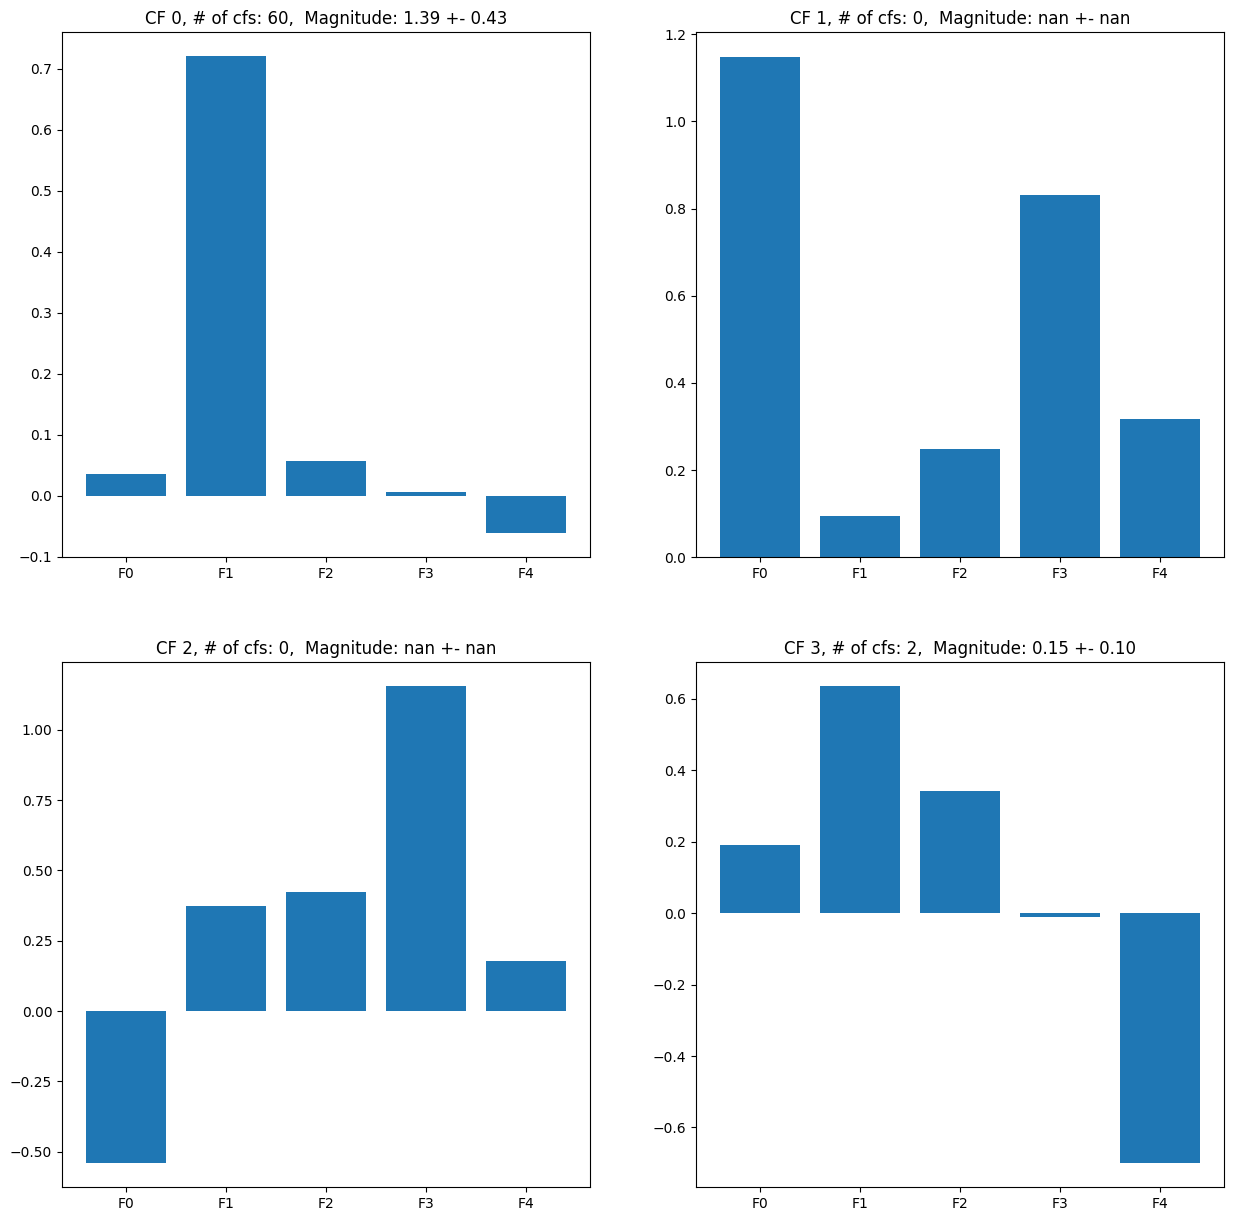

In [12]:
plt.figure(figsize=(15, 15))

groups = S.argmax(dim=1)

for i in range(D.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.bar(
        [f"F{feat_num}" for feat_num in dataset.actionable_features],
        D[i, dataset.actionable_features].detach().numpy(),
    )
    mean_magn = M.squeeze()[groups == i].mean(axis=0)
    std_magn = M.squeeze()[groups == i].std(axis=0)
    n_vectors = (S.argmax(axis=1) == i).sum()
    plt.title(
        f"CF {i}, # of cfs: {n_vectors},  Magnitude: {mean_magn:.2f} +- {std_magn:.2f}"
    )